# Partial Least Squares Regression (PLSR) for Spectral Analysis

This notebook implements a Partial Least Squares Regression (PLSR) analysis for spectral data, specifically focusing on predicting Total Rare Earth Elements (TotalREE) content based on spectral measurements.

## Overview

The analysis follows these main steps:
1. Data preparation and interval-based grouping
2. Cross-validation using group k-fold strategy
3. PLSR model fitting and prediction
4. Performance evaluation at sample and interval levels
5. Variable importance analysis using VIP scores

## Requirements

- Python 3.x
- Required libraries: numpy, pandas, matplotlib, scikit-learn
- Input data: spectral measurements in CSV format with wavelength columns

## How to use
1. Ensure `hullq_interval.csv` exists with `Depth` and `interval` columns (use `add_interval_column.py` if needed).
2. Run cells in order. Keep `RANDOM_STATE` fixed for reproducibility.

## Import Required Libraries

The following cell imports all necessary Python libraries for the analysis:
- `numpy` and `pandas` for data manipulation
- `matplotlib` for visualization
- `sklearn` components for model building and evaluation

In [1]:
from __future__ import annotations
from typing import List, Tuple
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, root_mean_squared_error

In [2]:
# ===============================================================
# SET RANDOM SEEDS FOR REPRODUCIBILITY
# ===============================================================
import random

RANDOM_STATE = 42

# Seed Python's built-in random
random.seed(RANDOM_STATE)

# Seed NumPy (used by scikit-learn and PLSRegression)
np.random.seed(RANDOM_STATE)

print(f"Random seeds set to {RANDOM_STATE} for reproducibility.")

Random seeds set to 42 for reproducibility.


### Wavelength Column Detection
Function to automatically detect wavelength columns in the dataset. It identifies columns that can be converted to floating-point numbers, assuming these represent spectral wavelengths.

In [3]:
def detect_wavelength_columns(df: pd.DataFrame, exclude: List[str]) -> List[str]:
  """Detects spectrum columns: names that can be converted to float.
  Ex.: "350", "350.5", "1412". Excludes columns listed in `exclude`.
  """
  wave_cols = []
  for col in df.columns:
    if col in exclude:
      continue
    try:
      float(col)
      wave_cols.append(col)
    except Exception:
      # not a numeric name -> not a wavelength
      pass
  if not wave_cols:
    raise ValueError(
      "No spectrum columns detected. Make sure the wavelength columns "
      "have numeric names (e.g., '350', '1412')."
    )
  # sort by numeric value of wavelength
  wave_cols = sorted(wave_cols, key=lambda c: float(c))
  return wave_cols

## Variable Importance in Projection (VIP)

Implementation of VIP scores calculation for PLS regression. VIP scores indicate the importance of each predictor (wavelength) in the PLS model:
- VIP > 1: variable is highly influential
- VIP < 1: variable is less influential

The implementation follows the standard formula used in chemometrics:
$VIP_j = \sqrt{\frac{p\sum_k(SSY_k(w_{jk}^2/\sum_j w_{jk}^2))}{SSY_{total}}}$

where:
- $p$ is the number of predictors
- $SSY_k$ is the sum of squares explained by component $k$
- $w_{jk}$ is the weight of variable $j$ in component $k$

In [4]:
# Implementation of VIP for PLS with one response variable (1D y).
# Standard formula reference in chemometrics.

def vip_scores(pls: PLSRegression, X: np.ndarray, y: np.ndarray) -> np.ndarray:
  """Calculates VIP (Variable Importance in Projection) for 1D PLS.
  Returns array shape (n_features,).
  """
  # Adjust for 1D y case
  if y.ndim == 2 and y.shape[1] == 1:
    y_vec = y.ravel()
  elif y.ndim == 1:
    y_vec = y
  else:
    raise ValueError("VIP implemented for 1D target. Provide a single target column.")


  T = pls.x_scores_ # (n_samples, n_comp)
  W = pls.x_weights_ # (n_features, n_comp)
  Q = pls.y_loadings_ # (n_comp, 1)


  # Sum of squares explained by component for y
  # SSY_k = (t_k^T t_k) * (q_k^T q_k)
  ssy = np.sum((T ** 2), axis=0) * (Q.ravel() ** 2)
  total_ssy = np.sum(ssy)


  # VIP_j = sqrt( p * sum_k( ssy_k * (w_jk^2 / sum_j(w_jk^2)) ) / total_ssy )
  p = W.shape[0]
  vip = np.zeros((p,), dtype=float)
  for j in range(p):
    weight = 0.0
    for k in range(W.shape[1]):
      wkj2 = W[j, k] ** 2
      denom = np.sum(W[:, k] ** 2)
      weight += ssy[k] * (wkj2 / denom)
    vip[j] = np.sqrt((p * weight) / (total_ssy + 1e-12))
  return vip

## Model Training and Cross-Validation

The analysis uses group k-fold cross-validation, where groups are defined by depth intervals. This ensures that all samples from the same depth interval are kept together either in training or test set.

Process:
1. Load and preprocess the data
2. Detect wavelength columns (predictors)
3. Set up cross-validation folds
4. Train PLS model on each fold
5. Calculate performance metrics and VIP scores

In [5]:
data_path = '../data/processed/hullq_interval.csv'
groupkfold_path = '../processing/folds_groupkfold.json'

# ===== Data Loading and Preprocessing =====
# Load and sort data by interval and depth
df = pd.read_csv(data_path).sort_values(["interval", "Depth"]).reset_index(drop=True)
df.rename(columns={'Unnamed: 0': 'Sample'}, inplace=True)

# # Create 'interval' column
# df["interval"] = df['Depth'].apply(depth_to_interval_label)

# df.to_csv('hullq_interval.csv', index=False)

# Load pre-defined cross-validation fold indices
with open(groupkfold_path, "r", encoding="utf-8") as f:
    fold_idx = json.load(f)

# ===== Feature Selection =====
# Define non-wavelength columns to exclude
exclude_cols = ['Sample', 'TotalREE', 'Depth', 'Mask']

# Get wavelength columns (spectral features)
wave_cols = detect_wavelength_columns(df, exclude=exclude_cols)
target_col = ["TotalREE"]

# ===== Data Matrix Preparation =====
# Convert data to numpy arrays for modeling
X = df[wave_cols].to_numpy(dtype=float)    # Spectral features
y = df[target_col].to_numpy(dtype=float)   # Target variable
groups = df.loc[:, "interval"].to_numpy()   # Group labels for CV
depths = df["Depth"].to_numpy(dtype=float)  # Depth values

# ===== Model Configuration =====
# Set number of PLS components (max 10)
n_comp = min(10, X.shape[1])
if n_comp < 1:
    raise ValueError("Invalid n_components.")

# Initialize storage for results
fold_rows = []       # Store metrics for each fold
pred_rows = []       # Store predictions for each sample
vip_accum = np.zeros(X.shape[1], dtype=float)   # Accumulate VIP scores
coef_accum = np.zeros(X.shape[1], dtype=float)  # Accumulate coefficients
fold_counter = 0

# ===== Cross-Validation Loop =====
for i, fdict in enumerate(fold_idx, 1):
    print(f"Fold: {i}")
    
    # Split data into train and test sets
    train_idx = np.array(fdict["train"], dtype=int)
    test_idx = np.array(fdict["test"], dtype=int)
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]
    
    print(f"Number of samples in X_train: {len(Xtr)}")
    print(f"Number of samples in X_test: {len(Xte)}")

    # Train and predict
    pls = PLSRegression(n_components=n_comp, scale=True)
    pls.fit(Xtr, ytr)
    ypred = pls.predict(Xte).ravel()

    # Calculate metrics
    r2 = r2_score(yte, ypred)
    rmse = root_mean_squared_error(yte, ypred)

    # Store test set predictions with metadata
    test_groups_vals = groups[test_idx]
    test_depths_vals = depths[test_idx]
    for yt, yp, d, grp in zip(yte, ypred, test_depths_vals, test_groups_vals):
        pred_rows.append({
            "fold": i,
            "interval": grp,
            "depth": float(d),
            "y_true": float(yt),
            "y_pred": float(yp),
        })

    # Calculate and store variable importances
    vip_fold = vip_scores(pls, Xtr, ytr)
    coef_fold = np.abs(pls.coef_).ravel()
    vip_accum += vip_fold
    coef_accum += coef_fold
    fold_counter += 1

    # Store fold results
    fold_rows.append({
        "fold": i,
        "r2": r2,
        "rmse": rmse,
        "train_groups": ",".join(sorted(set(map(str, groups[train_idx])))),
        "test_groups": ",".join(sorted(set(map(str, groups[test_idx])))),
    })

    print(f"Fold {i}: R2={r2:.3f}, RMSE={rmse:.3f}")

Fold: 1
Number of samples in X_train: 8893
Number of samples in X_test: 2254


C:\Users\thais\AppData\Local\Temp\ipykernel_5336\2302023288.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": float(yt),


Fold 1: R2=0.647, RMSE=1.461
Fold: 2
Number of samples in X_train: 8918
Number of samples in X_test: 2229


C:\Users\thais\AppData\Local\Temp\ipykernel_5336\2302023288.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": float(yt),


Fold 2: R2=0.773, RMSE=1.296
Fold: 3
Number of samples in X_train: 8916
Number of samples in X_test: 2231


C:\Users\thais\AppData\Local\Temp\ipykernel_5336\2302023288.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": float(yt),


Fold 3: R2=0.814, RMSE=1.191
Fold: 4
Number of samples in X_train: 8892
Number of samples in X_test: 2255


C:\Users\thais\AppData\Local\Temp\ipykernel_5336\2302023288.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": float(yt),


Fold 4: R2=0.861, RMSE=1.089
Fold: 5
Number of samples in X_train: 8969
Number of samples in X_test: 2178
Fold 5: R2=0.682, RMSE=1.184
Fold 5: R2=0.682, RMSE=1.184


C:\Users\thais\AppData\Local\Temp\ipykernel_5336\2302023288.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": float(yt),


## Results Analysis

The results are analyzed at two levels:

1. **Sample Level**: Performance metrics (R² and RMSE) for individual samples across all folds
2. **Interval Level**: Aggregated predictions for each depth interval (bag-level analysis)

The visualization includes:
- Grade profile showing real vs predicted values by depth
- Scatter plot of real vs predicted values
- Performance metrics summary


Average of folds (sample-level): R2=0.755 ± 0.089 | RMSE=1.244 ± 0.142
OOF (bag-level): R2=0.907 | RMSE=0.846 (interval average)


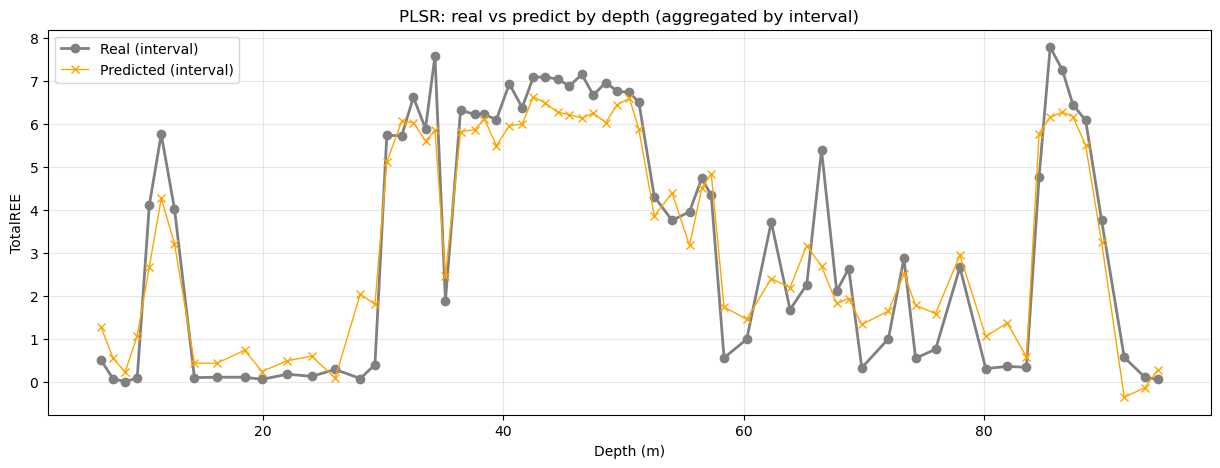

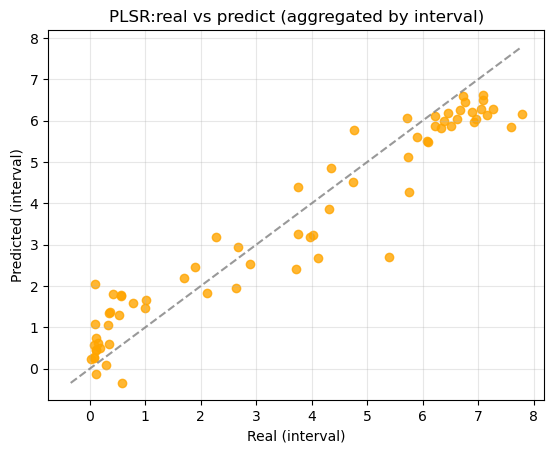

In [6]:
# ===== Performance Analysis =====

# Calculate average metrics across folds (sample-level)
metrics_df = pd.DataFrame(fold_rows)
if not metrics_df.empty:
    print(
        f"\nAverage of folds (sample-level): "
        f"R2={metrics_df['r2'].mean():.3f} ± {metrics_df['r2'].std():.3f} | "
        f"RMSE={metrics_df['rmse'].mean():.3f} ± {metrics_df['rmse'].std():.3f}"
    )

# ===== Interval-Level Analysis =====
# Aggregate predictions by interval (bag-level analysis)
preds_df = pd.DataFrame(pred_rows)

# Calculate interval-level metrics
agg = (
    preds_df
      .groupby("interval", as_index=False)
      .agg({
          "depth": "median",      # Representative depth
          "y_true": "mean",       # Average true value
          "y_pred": "mean",       # Average prediction
      })
      .sort_values("depth")
)

# Calculate performance metrics at interval level
r2_bag = r2_score(agg["y_true"], agg["y_pred"])
rmse_bag = root_mean_squared_error(agg["y_true"], agg["y_pred"])
print(f"OOF (bag-level): R2={r2_bag:.3f} | RMSE={rmse_bag:.3f} (interval average)")

# ===== Visualization =====
# Plot 1: Grade Profile
plt.figure(figsize=(15, 5))
plt.plot(agg["depth"], agg["y_true"], marker="o", label="Real (interval)", color='grey', linewidth=2)
plt.plot(agg["depth"], agg["y_pred"], marker="x", label="Predicted (interval)", color='orange', linewidth=1)
plt.xlabel("Depth (m)")
plt.ylabel("TotalREE")
plt.title("PLSR: real vs predict by depth (aggregated by interval)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("plsr_oof_profile.png", dpi=300)
plt.show()


# Plot 2: Scatter Plot
plt.figure()
plt.scatter(agg["y_true"], agg["y_pred"], alpha=0.8, color='orange')
# Add 1:1 line
lims = [
    min(agg["y_true"].min(), agg["y_pred"].min()),
    max(agg["y_true"].max(), agg["y_pred"].max())
]
plt.plot(lims, lims, '--', color='gray', alpha=0.8)
plt.xlabel("Real (interval)")
plt.ylabel("Predicted (interval)")
plt.title("PLSR:real vs predict (aggregated by interval)")
plt.grid(True, alpha=0.3)
plt.savefig("plsr_oof_scatter.png", dpi=300)
plt.show()


## Variable Importance Analysis

Calculate and analyze the importance of each wavelength using:
1. VIP scores averaged across all folds
2. Absolute coefficients from the PLS model

This helps identify which wavelengths are most important for predicting TotalREE content.

In [7]:
# ===== Variable Importance Analysis =====
# Calculate mean importance scores across folds
vip_mean = vip_accum / max(fold_counter, 1)
coef_mean = coef_accum / max(fold_counter, 1)

# Create DataFrame with wavelength importance metrics
imp_df = pd.DataFrame({
    "wavelength": [float(w) for w in wave_cols],
    "vip": vip_mean,
    "coef_abs": coef_mean
})

# Add importance rankings
imp_df["rank_vip"] = imp_df["vip"].rank(ascending=False, method="dense").astype(int)
imp_df["rank_coef"] = imp_df["coef_abs"].rank(ascending=False, method="dense").astype(int)

# Sort by VIP score (most important first)
imp_df = imp_df.sort_values(by=["vip"], ascending=False)

In [8]:
# ===== Final Results Summary =====
print("\n==== Summary ====")
if not metrics_df.empty:
    # Print detailed fold results
    print("\nCross-validation results by fold:")
    print(metrics_df.to_string(index=False))
    
    # Print top wavelengths by importance
    print("\nTop 20 most important wavelengths (by VIP score):")
    print(imp_df.head(20).to_string(index=False))


==== Summary ====

Cross-validation results by fold:
 fold       r2     rmse                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_groups                                                                                                                                     test_groups
    1 0.647057 1.461044                     11-12.007,13.5-15,15-17.6,19-21,21-23,23-25.007,25.007-27,27-29,29-29.6,29.6-31.008,31.008-32.007,32.007-33.007,33.007-34,34.6-35.9,37.008-38,38-39.008,39.008-40,40-41,41-42.007,42.0